# Pokemon Interpolator
A Convolutional Autoencoder (CAE) implementation in TensorFlow. The model extracts latent image features using the encoder and regenerates images from latent features using the decoder. By interpolating between compressed latent representations, a smoother image interpolation can be achieved.

## Importing

In [1]:
import json
import os

import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflowjs as tfjs

## Preprocessing

In [2]:
def preprocess(x, y=None):
    # The image resolution is increased to hide subtle reconstruction errors.
    # This comes with a memory and runtime cost.
    scaled = tf.image.resize_with_pad(x, 256, 256, "nearest") / 255
    return scaled, scaled

dataset = keras.utils.image_dataset_from_directory(
    directory="images",
    color_mode="rgba",
    image_size=(42, 56),
    batch_size=8,
    interpolation="nearest",
).map(preprocess)

Found 890 files belonging to 1 classes.


## Modeling

In [3]:
encoder = keras.Sequential([
    keras.layers.Conv2D(input_shape=(256, 256, 4), filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        18448     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                                 
Total params: 2,191,952
Trainable params: 2,191,952
Non-trainable params: 0
_________________________________________________________________


In [4]:
decoder = keras.Sequential([
    keras.layers.Dense(input_shape=(128,), units=16384),
    keras.layers.Reshape((32, 32, 16)),
    keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding="same", activation="sigmoid"),
])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             2113536   
                                                                 
 reshape (Reshape)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 128)      18560     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 64)     73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 256, 256, 32)     18464     
 ranspose)                                                       
                                                      

In [5]:
model = keras.Sequential([encoder, decoder])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128)               2191952   
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 4)       2225508   
                                                                 
Total params: 4,417,460
Trainable params: 4,417,460
Non-trainable params: 0
_________________________________________________________________


## Training

In [6]:
EPOCHS = 500
LR = 1e-3

In [7]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=keras.losses.MeanSquaredError())
model.fit(dataset, epochs=EPOCHS, callbacks=[keras.callbacks.TensorBoard()])

Epoch 1/500
112/112 [==============================] - 6s 31ms/step - loss: 0.0650
Epoch 2/500
112/112 [==============================] - 3s 30ms/step - loss: 0.0209
Epoch 3/500
112/112 [==============================] - 3s 30ms/step - loss: 0.0184
Epoch 4/500
112/112 [==============================] - 3s 30ms/step - loss: 0.0163
Epoch 5/500
112/112 [==============================] - 3s 30ms/step - loss: 0.0147
Epoch 6/500
112/112 [==============================] - 3s 30ms/step - loss: 0.0135
Epoch 7/500
112/112 [==============================] - 3s 30ms/step - loss: 0.0124
Epoch 8/500
112/112 [==============================] - 3s 30ms/step - loss: 0.0116
Epoch 9/500
112/112 [==============================] - 3s 30ms/step - loss: 0.0106
Epoch 10/500
112/112 [==============================] - 3s 30ms/step - loss: 0.0099
Epoch 11/500
112/112 [==============================] - 3s 30ms/step - loss: 0.0093
Epoch 12/500
112/112 [==============================] - 3s 30ms/step - loss: 0.0087
E

## Evaluating

In [8]:
def plot_pokemon(count=5, figsize=(10, 20)):
    f, axes = plt.subplots(count, 2, figsize=figsize)

    for row in axes:
        row[0].set_title("Real")
        row[1].set_title("Generated")

        for ax in row:
            ax.set_xticks([])
            ax.set_yticks([])

    for i,(x, _) in enumerate(dataset.take(count)):
        axes[i][0].imshow(x[0])
        axes[i][1].imshow(model(x)[0])

    plt.show()

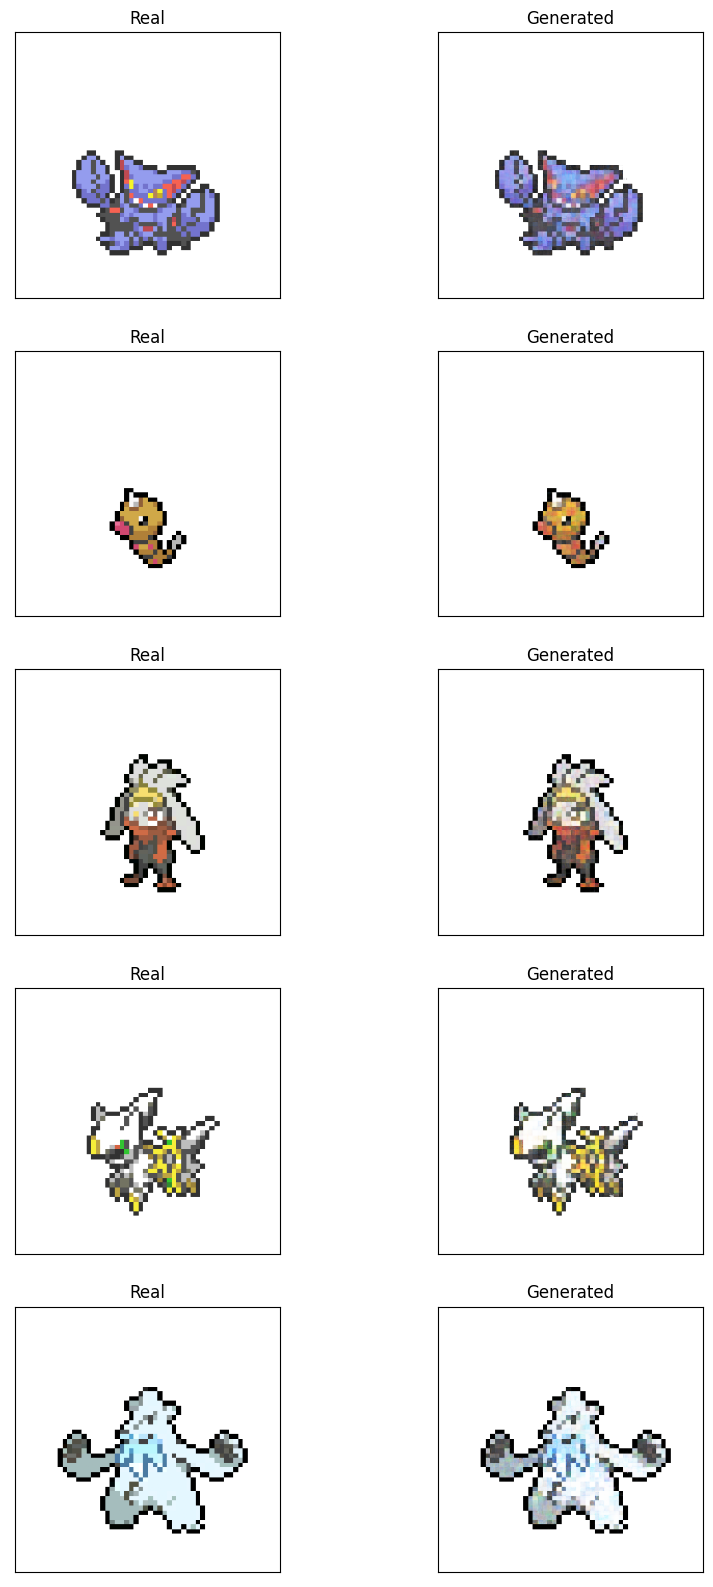

In [9]:
plot_pokemon()

In [10]:
def merge_pokemon(ratio=0.5):
    batch = next(iter(dataset))
    samples = batch[0][:2]
    codes = model.layers[0](samples)
    merged = ratio*codes[0] + (1-ratio)*codes[1]
    decoded = model.layers[1](tf.expand_dims(merged, axis=0))[0]

    f, axes = plt.subplots(1, 3, figsize=(20, 10))
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    axes[0].imshow(samples[0])
    axes[1].imshow(decoded)
    axes[2].imshow(samples[1])

    plt.show()

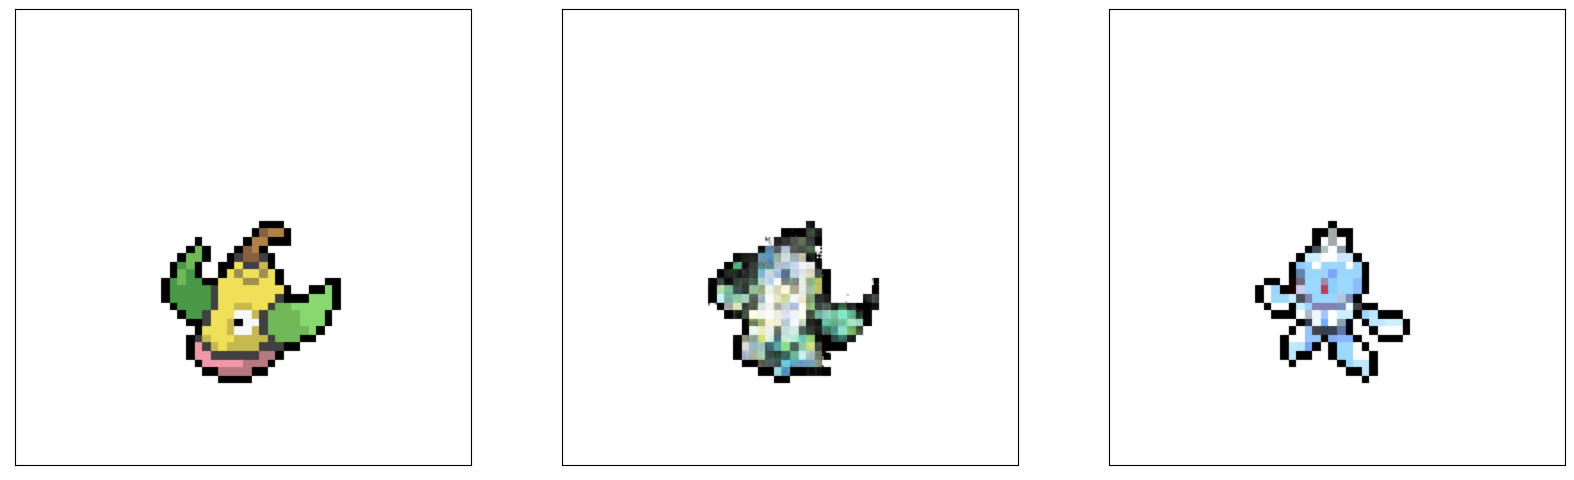

In [11]:
merge_pokemon()

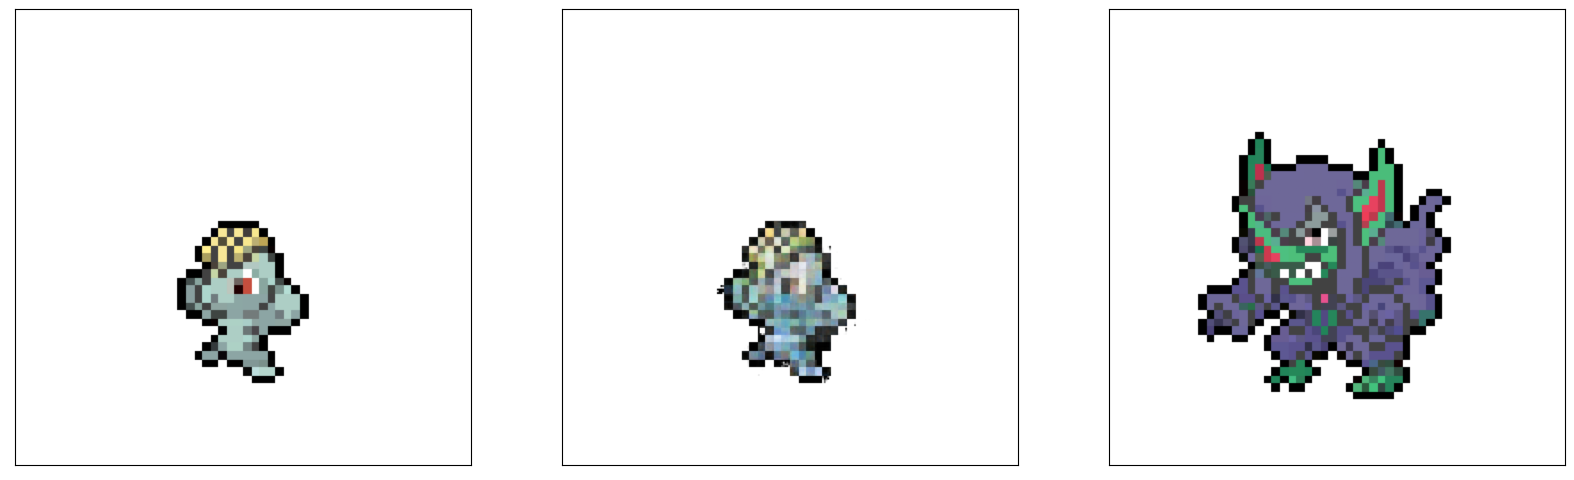

In [12]:
merge_pokemon(0.9)

## Exporting

In [13]:
model.save("export/CAE.keras")
tfjs.converters.save_keras_model(model.layers[1], "export/decoder")

In [14]:
codes = {}
for file in os.listdir("images/swsh"):
    pokemon = os.path.splitext(file)[0]
    filepath = os.path.join("images", "swsh", file)
    img, _ = preprocess(keras.utils.img_to_array(keras.utils.load_img(filepath, color_mode="rgba")))
    codes[pokemon] = model.layers[0](tf.expand_dims(img, 0))[0].numpy().tolist()

with open("export/codes.json", "w") as f:
    json.dump(codes, f)